In [2]:
import pandas as pd
from google.colab import files

file = files.upload()
data = pd.read_csv('StudentPerformance.csv')

Saving StudentPerformance.csv to StudentPerformance (1).csv


**Exploratory Data Analysis**

In [7]:
data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [15]:
data.sample()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
552,1,93,Yes,6,8,68.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [12]:
data.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [13]:
data.isnull().sum()

,0
Hours Studied,0
Previous Scores,0
Extracurricular Activities,0
Sleep Hours,0
Sample Question Papers Practiced,0
Performance Index,0


In [22]:
data.nunique()

,0
Hours Studied,9
Previous Scores,60
Extracurricular Activities,2
Sleep Hours,6
Sample Question Papers Practiced,10
Performance Index,91


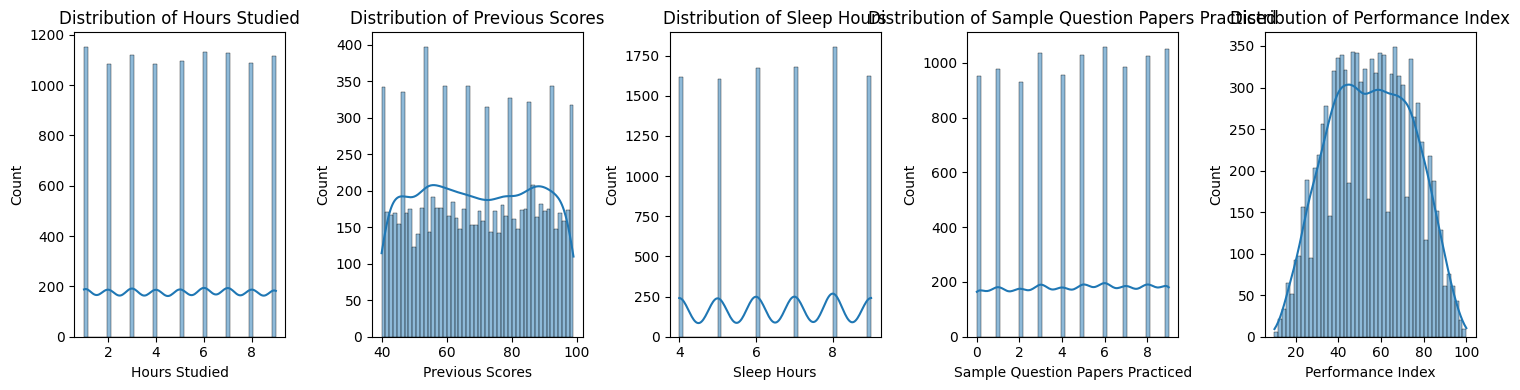

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ['Hours Studied','Previous Scores','Sleep Hours',
        'Sample Question Papers Practiced','Performance Index']

plt.figure(figsize=(15,4))

for i,col in enumerate(cols,1):
  plt.subplot(1,5,i)
  sns.histplot(data[col],bins=50,kde=True)
  plt.title(f'Distribution of {col}')


plt.tight_layout()
plt.show()

*There are no empty columns, and there are no other anomalies in the data, so we can skip data cleaning and move on to the data split stage.*

**Split Data**

In [29]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='Performance Index')
y = data['Performance Index']

TrainX,ValX,TrainY,ValY = train_test_split(
    X,y,test_size=0.3,random_state=42
)

numeric_features = TrainX.select_dtypes(include=['int64','float64']).columns
categorical_features = TrainX.select_dtypes(include=['object']).columns


TrainX.shape, ValX.shape

((7000, 5), (3000, 5))

**Preprocessing Pipeline**

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn.preprocessing import OrdinalEncoder

numeric_transform = Pipeline(steps=[
    ('Scaler',StandardScaler())
])

categorical_transform = Pipeline(steps=[
    ('ordinal',OrdinalEncoder(categories=[['No','Yes']]))
])

In [34]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_transform,numeric_features),
        ('cat',categorical_transform,categorical_features)
    ]

)


**Mutual Information**

In [37]:
from sklearn.feature_selection import mutual_info_regression

TrainXMI = preprocessor.fit_transform(TrainX)

name = list(numeric_features) + list(categorical_features)

mi_scores = mutual_info_regression(
    TrainXMI,TrainY,random_state=42
)

mi_series = pd.Series(mi_scores,index=name)
mi_series = mi_series.sort_values(ascending=False)

mi_series

,0
Previous Scores,0.931743
Hours Studied,0.162866
Sleep Hours,0.011652
Sample Question Papers Practiced,0.001808
Extracurricular Activities,0.000000


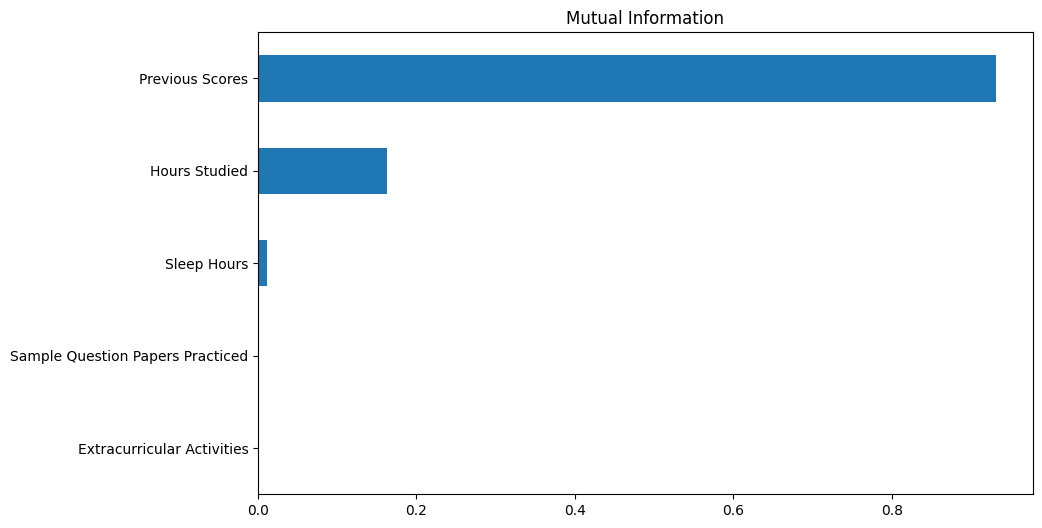

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
mi_series.head(5).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Mutual Information")

plt.show()